In [1]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from brainmdd.features.psd import EEGPowerSpectrum
import mne
import enum

dotenv.load_dotenv()



class ChannelMapping(enum.Enum):
    Fp1 = 22
    Fp2 = 9
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

# Declare Global Variables
NUM_CHANNELS = 16
MODMA_SFREQ = 250
EEG_DIR_PATH = os.getenv("EEG_DIR_PATH")
RAW_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/raw"
SELECT_16_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/16channels"
FILTERED_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/filtered"
EPOCHS_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/epochs"

# Declare Feature Dictionary
featureDict = {
    "norm_power": {
        "mdd": {
            "delta": [],
            "theta": [],
            "alpha": [],
            "beta": [],
            "gamma": []
            },
        "control": {
            "delta": [],
            "theta": [],
            "alpha": [],
            "beta": [],
            "gamma": []
            }
        }
    }    


In [2]:
# Load the epochs
mddEpochs = mne.read_epochs(EPOCHS_DIR_PATH + "/mdd-epo.fif")
controlEpochs = mne.read_epochs(EPOCHS_DIR_PATH + "/control-epo.fif")
mddEpochs = mddEpochs.get_data()
controlEpochs = controlEpochs.get_data()

Reading /Users/wachiii/Workschii/brain-mdd/data/epochs/mdd-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4996.00 ms
        0 CTF compensation matrices available
Not setting metadata
1328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/wachiii/Workschii/brain-mdd/data/epochs/control-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4996.00 ms
        0 CTF compensation matrices available
Not setting metadata
1753 matching events found
No baseline correction applied
0 projection items activated


In [3]:
psdObjMdd = EEGPowerSpectrum(mddEpochs, 250, ifNormalize=True)
mddPsdFeatures = psdObjMdd.run()
psdObjCtrl = EEGPowerSpectrum(controlEpochs, 250, ifNormalize=True)
controlPsdFeatures = psdObjCtrl.run()
print(mddPsdFeatures.shape)
print(controlPsdFeatures.shape)

(1328, 5, 16)
(1753, 5, 16)


In [4]:
for epoch in mddPsdFeatures:
    bandCounter = 0
    for band in epoch:
        if bandCounter == 0:
            featureDict["norm_power"]["mdd"]["delta"].append(band)
        elif bandCounter == 1:
            featureDict["norm_power"]["mdd"]["theta"].append(band)
        elif bandCounter == 2:
            featureDict["norm_power"]["mdd"]["alpha"].append(band)
        elif bandCounter == 3:
            featureDict["norm_power"]["mdd"]["beta"].append(band)
        elif bandCounter == 4:
            featureDict["norm_power"]["mdd"]["gamma"].append(band)
        bandCounter += 1

for epoch in controlPsdFeatures:
    bandCounter = 0
    for band in epoch:
        if bandCounter == 0:
            featureDict["norm_power"]["control"]["delta"].append(band)
        elif bandCounter == 1:
            featureDict["norm_power"]["control"]["theta"].append(band)
        elif bandCounter == 2:
            featureDict["norm_power"]["control"]["alpha"].append(band)
        elif bandCounter == 3:
            featureDict["norm_power"]["control"]["beta"].append(band)
        elif bandCounter == 4:
            featureDict["norm_power"]["control"]["gamma"].append(band)
        bandCounter += 1                                                           

(1328, 16)
(1753, 16)


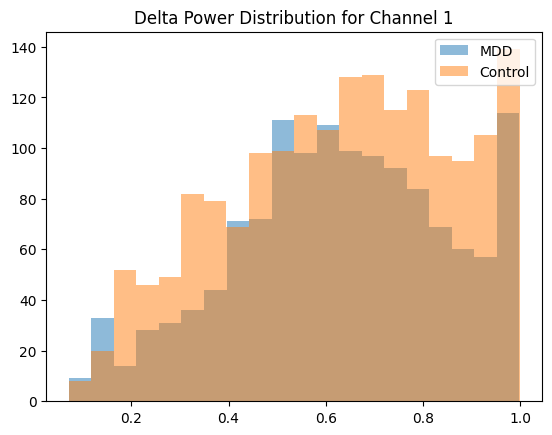

In [13]:
# check distribution of features, p-values, etc.

# histogram of delta power
deltaMdd = featureDict["norm_power"]["mdd"]["delta"]
deltaCtrl = featureDict["norm_power"]["control"]["delta"]
deltaMdd = np.array(deltaMdd)
deltaCtrl = np.array(deltaCtrl)
print(deltaMdd.shape)
print(deltaCtrl.shape)
# for loop check normal distribution for each channel
deltaMddCh1 = deltaMdd[:, 0]
deltaCtrlCh1 = deltaCtrl[:, 0]

plt.hist(deltaMddCh1, bins=20, alpha=0.5, label='MDD')
plt.hist(deltaCtrlCh1, bins=20, alpha=0.5, label='Control')
plt.legend(loc='upper right')
plt.title("Delta Power Distribution for Channel 1")
plt.show()



In [16]:
import numpy as np
from statsmodels.stats.multitest import fdrcorrection

# Example data: features from 16 EEG channels (e.g., power spectral density)
np.random.seed(42)  # For reproducibility
group1 = np.random.rand(10, 16)  # Healthy group: 10 epochs, 16 channels
group2 = np.random.rand(12, 16)  # MDD group: 12 epochs, 16 channels

# Number of permutations
num_permutations = 10000
num_channels = group1.shape[1]
p_values = []

# Perform permutation tests for each channel
for ch in range(num_channels):
    observed_stat = np.mean(group1[:, ch]) - np.mean(group2[:, ch])
    
    # Pool the data
    pooled_data = np.hstack((group1[:, ch], group2[:, ch]))
    perm_stats = []
    
    for _ in range(num_permutations):
        np.random.shuffle(pooled_data)
        perm_group1 = pooled_data[:len(group1)]
        perm_group2 = pooled_data[len(group1):]
        perm_stat = np.mean(perm_group1) - np.mean(perm_group2)
        perm_stats.append(perm_stat)
    
    # Calculate p-value
    perm_stats = np.array(perm_stats)
    p_value = np.mean(np.abs(perm_stats) >= np.abs(observed_stat))
    p_values.append(p_value)

# Convert list of p-values to an array
p_values = np.array(p_values)

# Apply FDR correction
fdr_corrected, fdr_significant = fdrcorrection(p_values, alpha=0.05)

# Results
for ch in range(num_channels):
    print(f"Channel {ch + 1}: p-value = {p_values[ch]:.2f}, "
          f"FDR-corrected significant = {fdr_significant[ch]}")

Channel 1: p-value = 0.14, FDR-corrected significant = 0.5334399999999999
Channel 2: p-value = 0.52, FDR-corrected significant = 0.6866666666666666
Channel 3: p-value = 0.59, FDR-corrected significant = 0.7297230769230769
Channel 4: p-value = 0.11, FDR-corrected significant = 0.5334399999999999
Channel 5: p-value = 0.08, FDR-corrected significant = 0.5334399999999999
Channel 6: p-value = 0.17, FDR-corrected significant = 0.5334399999999999
Channel 7: p-value = 0.42, FDR-corrected significant = 0.66784
Channel 8: p-value = 0.74, FDR-corrected significant = 0.7442
Channel 9: p-value = 0.67, FDR-corrected significant = 0.7442
Channel 10: p-value = 0.74, FDR-corrected significant = 0.7442
Channel 11: p-value = 0.10, FDR-corrected significant = 0.5334399999999999
Channel 12: p-value = 0.33, FDR-corrected significant = 0.653688888888889
Channel 13: p-value = 0.24, FDR-corrected significant = 0.5499428571428572
Channel 14: p-value = 0.49, FDR-corrected significant = 0.6866666666666666
Channel